# Inversion benchmark - centroid distance

Define a set of points around the boundary of a lithology then use their distance to the centroid as an inversion variable. It only has one degree of freedom (_expansion_ and _contraction_) but with enough points this should not matter.

> **Problem statement**: We need a way to relate the spatial arrangement of nodes to lithology that is _differentiable_.

In [18]:
import numpy as np
from time import clock
from conduction import ConductionND
from conduction.inversion import InvObservation, InvPrior
from conduction import InversionND
import matplotlib.pyplot as plt
%matplotlib inline

from petsc4py import PETSc
from mpi4py import MPI
comm = MPI.COMM_WORLD

from scipy import ndimage

In [19]:
minX, maxX = 0.0, 1000.0
minY, maxY = -1000.0, 0.0
nx, ny = 50, 50
n = nx*ny

mesh = ConductionND((minX, minY), (maxX, maxY), (nx,ny))

# BCs
mesh.boundary_condition('maxY', 298.0, flux=False)
mesh.boundary_condition('minY', 1e3, flux=True)


# Global lithology

lithology = np.zeros((ny,nx), dtype='int32')
lithology[3:7,:] = 1
lithology[7:,:]  = 2

lithology_ratios = np.empty_like(lithology, dtype=np.float)

ratio0 = 1.0/(lithology == 0).sum()
ratio1 = 1.0/(lithology == 1).sum()
ratio2 = 1.0/(lithology == 2).sum()

lithology_ratios.fill(ratio0)
lithology_ratios[3:7,:] = ratio1
lithology_ratios[7:, :] = ratio2


# Need to slice this bad boy up: Local lithology

(minI, maxI), (minJ, maxJ) = mesh.dm.getGhostRanges()
lithology = lithology[minJ:maxJ, minI:maxI]

In [20]:
inv = InversionND(lithology.flatten(), mesh)

k = np.array([3.5, 2.0, 3.2])
H = np.array([0.5e-6, 1e-6, 2e-6])
a = np.array([0.3, 0.3, 0.3])
q0 = 35e-3
sigma_q0 = 5e-3


# Inversion variables
x = np.hstack([k, H, a, [q0], lithology_ratios.flatten()])
dx = x*0.01
dx[:10] = 0.0

## Find boundary points

We only have to do this once to find the point coordinates.

Lithology transitions are sharp, and the boundary points must be located at "imaginary" nodes between the mesh.

1. Use the sobel filter to identify lithology transitions (thickness of two cells)
2. Iterate through lithologies, reducing sobel points to within the lithology and outside.
3. Find the boundary (centroid) between points within lithology and neighbours that are within sobel filter.

In [21]:
sobel_bands = []
for i in xrange(inv.mesh.dim):
    sobel_bands.append( ndimage.sobel(lithology, axis=i) )
    
sobel_bands = np.linalg.norm(sobel_bands, axis=0)

bands = np.nonzero(sobel_bands)
node_bands = np.nonzero(sobel_bands.ravel())[0]

In [22]:
neighbours = mesh.find_neighbours()

node_bands_mask = np.zeros(mesh.nn, dtype=bool)
node_bands_mask[node_bands] = True

bpoints = [[] for _ in range(len(inv.lithology_index))]

for l, lith in enumerate(inv.lithology_index):
    lith_mask = lith == inv.lithology
    lith_band  = np.nonzero(np.logical_and(lith_mask, node_bands_mask))[0]
    other_band = np.nonzero(np.logical_and(~lith_mask, node_bands_mask))[0]
    for node in lith_band:
        # iterate through points along the boundary
        neighbour_nodes = neighbours[node]
        neighbour_set = set(neighbour_nodes).intersection(other_band)
        for nnode in neighbour_set:
            # iterate through neighbouring points along the boundary
            bpt = 0.5*(mesh.coords[node] + mesh.coords[nnode])
            bpoints[l].append( bpt )

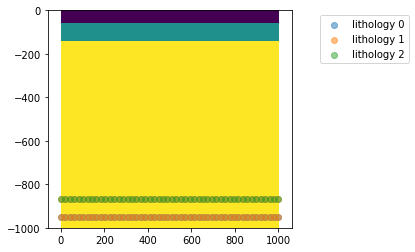

In [23]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.imshow(lithology, extent=mesh.extent)
for l, lith in enumerate(inv.lithology_index):
    bpts = np.vstack(bpoints[l])
    ax1.scatter(bpts[:,0], bpts[:,1], alpha=0.5, label="lithology {}".format(lith))
ax1.legend(bbox_to_anchor=(1.5,1))

## Map lithologies within hull of boundary points

The boundary points are going to deform so we need map the volume contained by the boundary points to lithologies. We need to ensure nodes at the BCs remain fixed.

1. Connect up the boundary points (and BC nodes)
2. Mask all nodes contained within the hull of boundary points using a flood-fill algorithm
3. Repeat for every lithology

## Integrated vertical flux

A simple alternative is to fix the lateral motion of nodes and only facilitate movement in the vertical direction.

We know that in 1D:

$$
q_s = \int_z H \, \mathrm{d}z + q_m
$$

which is approximately true for 2D and 3D simulations, where a smaller fraction of heat flux is attributed to a lateral component. If we partition the domain into two lithologies, $A$ and $B$, stacked vertically, then we expand the above formula:

$$
\begin{align*}
q_s =& q_A + q_B + q_m \\
    =& H_A (z_s - z_{AB}) + H_B (z_{AB} - z_m) + q_m
\end{align*}
$$

where $z_s, z_{AB}$ and $z_m$ is the $z$ coordinate of the surface, the intersection between $A$-$B$, and the bottom of the domain, respectively. The derivatives of $q_s$ with respect to these coordinates are:

$$
\begin{align*}
\frac{\partial q_s}{\partial z_s}    &= H_A \\
\frac{\partial q_s}{\partial z_{AB}} &= -H_A + H_B \\
\frac{\partial q_s}{\partial z_m}    &= -H_B 
\end{align*}
$$

This demonstrates the derivative of the $z$ coordinate interesecting vertically stacked lithologies $L_1, L_2, \ldots, L_n$ is the difference between the heat production of the lower lithology to the overlying lithology.

$$
\frac{\partial q_s}{\partial z_{L}} = H_{L+1} - H_{L}
$$

## Integrated vertical flux II

A simple alternative is to fix the lateral motion of nodes and only facilitate movement in the vertical direction.

We know that in 1D:

$$
q_s = \int_z H \, \mathrm{d}z + q_m
$$

which is approximately true for 2D and 3D simulations, where a smaller fraction of heat flux is attributed to a lateral component. If we partition the domain into two lithologies, $A$ and $B$, stacked vertically, then we expand the above formula:

$$
\begin{align*}
q_s =& q_A + q_B + q_m \\
    =& H_A \Delta z_A + H_B \Delta z_B + q_m
\end{align*}
$$

where $z_s, z_{AB}$ and $z_m$ is the $z$ coordinate of the surface, the intersection between $A$-$B$, and the bottom of the domain, respectively. The derivatives of $q_s$ with respect to these coordinates are:

$$
\begin{align*}
\frac{\partial q_s}{\partial \Delta z_A}  &= H_A \\
\frac{\partial q_s}{\partial \Delta z_B}  &= H_B \\
\end{align*}
$$


In [24]:
def vfill(self):
    """
    Flood-fill algorithm for the vertical axes
    """
    def query_nearest(l):
        layer_mask.fill(0)

        yq = spl[l].ev(xq)
        d, idx = tree.query(np.column_stack([xq, yq]))
        layer_mask.flat[idx] = True

        return np.where(layer_mask)

    tree = self.ndinterp.tree
    layer_voxel = np.zeros_like(lithology)
    layer_mask = np.zeros_like(lithology, dtype=bool)
    
    nl = len(self.lithology_index)

    for l in xrange(nl):
        i0, j0 = query_nearest(l)

        for i in xrange(i0.size):
            layer_voxel[:i0[i], j0[i]] = l

        print("mapped layer {}".format(l))

In [25]:
def forward_model(x, nbpts, self):
    nl = len(self.lithology_index)
    H = x[:nl] # just H for demonstration purposes
    q0 = x[nl]
    bpts = np.split(x[nl+1:], nbpts) # nbpts are integers specifying how many points belong to each lithology in x
    
    lithology = self.lithology.reshape(self.mesh.n)
    qc = []
    
    for l, lith in enumerate(self.lithology_index):
        mask = lithology == lith
        nrow = mask.sum(axis=0)
        dz = nrow*self.grid_delta[-1]
#         z0 = bpts[l]
#         qc = H[l]*(z0 - z1)
        qc.append( H[l]*dz )
    
    qs = np.vstack(qc).sum(axis=0)
    return np.sum((qs - qobs)**2/sigma_qobs**2)

def tangent_linear(x, dx, nbpts, self):
    nl = len(self.lithology_index)
    H = x[:nl]
    q0 = x[nl]
    dH = dx[:nl]
    dq0 = dx[nl]
    
    bpts = np.split(x[nl+1:], nbpts)
    dbpts = np.split(dx[nl+1:], nbpts)
    
    lithology = self.lithology.reshape(self.mesh.n)
    qc = []
    
    for l, lith in enumerate(self.lithology_index):
        nrow = (lithology == lith).sum(axis=0)
        dz = nrow*self.grid_delta[-1]
        
        qc.append( H[l]*dz )
    
    qs = np.vstack(qc).sum(axis=0)
    cost = np.sum((qs - qobs)**2/sigma_qobs**2)

In [47]:
def forward_model(x, ncol, self):
    nl = len(self.lithology_index)
    H = x[:nl]
    q0 = x[nl]
    
    # ratios are grouped per lithology
    ratios = np.split(x[nl+1:], nl)
    
    # normalise all ratios to the range [0:1]
    vratios = np.vstack(ratios)
    vratios /= vratios.sum(axis=0)
    
    # determine number of cells per lithology
    ncells = vratios*self.mesh.n[-1]
    deltaZ = ncells*self.grid_delta[-1]
    qs = (H.reshape(-1,1)*deltaZ).sum(axis=0)
    
    cost = np.sum((qs - qobs)**2/sigma_qobs**2)
    cost += np.sum((H - Hobs)**2/sigma_Hobs**2)
    return cost
    
def tangent_linear(x, dx, ncol, self):
    nl = len(self.lithology_index)
    H = x[:nl]
    q0 = x[nl]
    dH = dx[:nl]
    dq0 = dx[nl]
    
    # ratios are grouped per lithology
    ratios = np.split(x[nl+1:], nl)
    dratios = np.split(dx[nl+1:], nl)
    
    # normalise all ratios to the range [0:1]
    vratios = np.vstack(ratios)
    vratio_norm = vratios/vratios.sum(axis=0)
    
    # vrN = vr/vrsum
    # dvrN/dvr = 1/vrsum
    # dvrN/dvrsum = -vr/vrsum**2
    # dvr = dvrN/dvr*dvr + dvrN/dvrsum * dvrsum
    dvrNdvrsum = -vratios/(vratios.sum(axis=0)**2)
    dvrNdvr = 1.0/vratios.sum(axis=0)
    dvratios = np.vstack(dratios)
    dvratios = dvrNdvr*dvratios + dvrNdvrsum*dvratios.sum(axis=0)
    #vratios*dvratios.sum(axis=0)
    print dvratios

    
    # determine number of cells per lithology
    ncells = vratio_norm*self.mesh.n[-1]
    deltaZ = ncells*self.grid_delta[-1]
    qs = (H.reshape(-1,1)*deltaZ).sum(axis=0)
    
    # nc = vrnorm * n
    # dnc/dvr = n
    # dnc = dnc/dvr * dvr
    dncells = self.mesh.n[-1] * dvratios
    
    # delZ = nc * dz
    # ddelZ/dnc = dz
    # ddelZ = ddelZ/dnc * dnc
    ddeltaZ = self.grid_delta[-1]*dncells
    
    # qs = sum( H*delZ )
    # dqs/dH = delZ
    # dqs/ddelZ = H
    # dqs = sum( dqs/dH * dH + dqs/ddelZ * ddelZ)
    dqs = np.sum( deltaZ*dH.reshape(-1,1) + H.reshape(-1,1)*ddeltaZ, axis=0)
    
    
    cost = np.sum((qs - qobs)**2/sigma_qobs**2)
    cost += np.sum((H - Hobs)**2/sigma_Hobs**2)
    dcdqs = (2.0*qs - 2.0*qobs)/sigma_qobs**2
    dcdH  = (2.0*H  - 2.0*Hobs)/sigma_Hobs**2
    dc = np.sum(dcdqs*dqs) + np.sum(dcdH*dH)
    return cost, dc

def adjoint_model(x, ncol, self):
    ## FORWARD MODEL
    nl = len(self.lithology_index)
    H = x[:nl]
    q0 = x[nl]
    
    # ratios are grouped per lithology
    ratios = np.split(x[nl+1:], nl)
    
    # normalise all ratios to the range [0:1]
    vratios = np.vstack(ratios)
    vratio_norm = vratios/vratios.sum(axis=0)
    
    # determine number of cells per lithology
    ncells = vratio_norm*self.mesh.n[-1]
    deltaZ = ncells*self.grid_delta[-1]
    qs = (H.reshape(-1,1)*deltaZ).sum(axis=0)
    
    cost = np.sum((qs - qobs)**2/sigma_qobs**2)
    cost += np.sum((H - Hobs)**2/sigma_Hobs**2)
    
    ## ADJOINT MODEL
    dqs = (2.0*qs - 2.0*qobs)/sigma_qobs**2
    dH  = (2.0*H  - 2.0*Hobs)/sigma_Hobs**2
    
    # qs = sum( H*delZ )
    # dqs/dH = delZ
    # dqs/ddelZ = H
    ddelZ = H.reshape(-1,1)*dqs
    dH += (deltaZ*dqs).sum(axis=1) # pack dH into (nl,1) vector
    
    # delZ = nc * dz
    # ddelZ/dnc = dz
    dnc = self.grid_delta[-1]*ddelZ
    
    # nc = vrN * n
    # dnc/dvrN = n
    dvrN = self.mesh.n[-1]*dnc
    
    # vrN = vr/vrsum
    # dvrN/dvr = 1/vrsum
    # dvrN/dvrsum = -vr/vrsum**2
    dvrNdvrsum = -vratios/(vratios.sum(axis=0)**2)
    dvrNdvr = 1.0/vratios.sum(axis=0)
    
    dvrsum = dvrNdvrsum*dvrN
    dvr = dvrNdvr*dvrN
    dvr += np.sum(dvrsum,axis=0)
    
    dq0 = 0.0
    gradient = np.hstack([dH, [dq0], dvr.ravel()])
    
    if self.log == True:
        self.store.append(x.copy())
        self.niter += 1
    return cost, gradient

In [50]:
qobs = np.ones(nx)
sigma_qobs = qobs / 10.

Hobs = np.ones_like(H)
sigma_Hobs = Hobs*1e-3

ncol = lithology.shape[0]

nl = len(inv.lithology_index)
ratio = np.empty((nl, nx))
ratio[0] = 0.2
ratio[1] = 0.3
ratio[2] = 0.5

dratio = np.zeros((nl, nx))
dratio[0,5:] = -0.1 # change the thickness of the top lithology
dratio[1,5:] = 0.3 # change the thickness of the mid lithology

x  = np.hstack([H, [q0], ratio.ravel()])
dx = np.hstack([H*0.0, [q0*0.0], dratio.ravel()])


In [51]:
fm0 = forward_model(x, ncol, inv)
fm1 = forward_model(x+dx, ncol, inv)
tl  = tangent_linear(x, dx, ncol, inv)
ad  = adjoint_model(x, ncol, inv)


print("finite difference {}".format(fm1 - fm0))
print("tangent linear {}".format(tl[1]))
print("adjoint model {}".format(ad[1].dot(dx)))

[[ 0.    0.    0.    0.    0.   -0.14 -0.14 -0.14 -0.14 -0.14 -0.14 -0.14
  -0.14 -0.14 -0.14 -0.14 -0.14 -0.14 -0.14 -0.14 -0.14 -0.14 -0.14 -0.14
  -0.14 -0.14 -0.14 -0.14 -0.14 -0.14 -0.14 -0.14 -0.14 -0.14 -0.14 -0.14
  -0.14 -0.14 -0.14 -0.14 -0.14 -0.14 -0.14 -0.14 -0.14 -0.14 -0.14 -0.14
  -0.14 -0.14]
 [ 0.    0.    0.    0.    0.    0.24  0.24  0.24  0.24  0.24  0.24  0.24
   0.24  0.24  0.24  0.24  0.24  0.24  0.24  0.24  0.24  0.24  0.24  0.24
   0.24  0.24  0.24  0.24  0.24  0.24  0.24  0.24  0.24  0.24  0.24  0.24
   0.24  0.24  0.24  0.24  0.24  0.24  0.24  0.24  0.24  0.24  0.24  0.24
   0.24  0.24]
 [ 0.    0.    0.    0.    0.   -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1
  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1
  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1
  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1
  -0.1  -0.1 ]]
finite difference 0.229266776703
tangent linear 0.275116618076
adjoint

We need to update `self.lithology` if the heat flow solver is going to do anything, but this is the crux of our story.

Remember to bound each ratio along the lateral plane with $[0,1]$.

In [52]:
def construct_lithology(self, ncells):
    lithology_new = np.zeros(self.mesh.n, dtype=np.int)
    
    ncol = self.mesh.n[0]
    
    ncells_int = np.round(ncells).astype(np.int)
    remainder = (ncol - ncells_int.sum(axis=0))
    
    # give remainder (pos/neg) to least cleanly divisible
    distribute = np.argmax(ncells % 1.0, axis=0)
    ncells_int[distribute] += remainder
    
    ncells_pad = np.pad(ncells_int, [[1,0], [0,0]], 'constant')
    ncells_sum = np.cumsum(ncells_pad, axis=0)
    ncells_sum[-1] = ncol
    
    for l, lith in enumerate(self.lithology_index):
        i0 = ncells_sum[l]
        i1 = ncells_sum[l+1]

        for i in xrange(i0.size):
            lithology_new[i0[i]:i1[i],i] = lith
    
    return lithology_new

def forward_model_ncells(x, ncol, self):
    nl = len(self.lithology_index)
    H = x[:nl]
    q0 = x[nl]
    
    # ratios are grouped per lithology
    ratios = np.split(x[nl+1:], nl)
    
    # normalise all ratios to the range [0:1]
    vratios = np.vstack(ratios)
    vratios /= vratios.sum(axis=0)
    
    # determine number of cells per lithology
    ncells = (vratios*self.mesh.n[-1])#.astype(np.int)
    return ncells

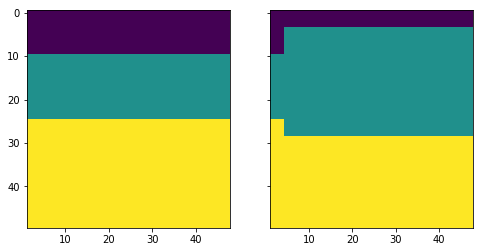

In [53]:
ncells   = forward_model_ncells(x, ncol, inv)
lith_x   = construct_lithology(inv, ncells)

ncells   = forward_model_ncells(x+dx, ncells, inv)
lith_xdx = construct_lithology(inv, ncells)


fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax1.imshow(lith_x)
ax2.imshow(lith_xdx)

In [55]:
from scipy.optimize import minimize

bounds_lower = np.hstack([[0.0, 0.0, 0.0, 0.0], np.ones(ratio.size)*1e-12])
bounds_upper = np.hstack([[1e99, 1e99, 1e99, 1e99], np.ones(ratio.size)])
bounds = list(zip(bounds_lower, bounds_upper))

qobs = np.sin(np.linspace(0, 2.0*np.pi, nx)) + 2.0
sigma_qobs = np.ones(nx)*0.0001

# this doesn't work for TNC strangely
res = minimize(adjoint_model, x, args=(ncol, inv), jac=True, bounds=bounds)
res

      fun: 15603376.545367964
 hess_inv: <154x154 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.55468935e+09,  7.11935095e+08, -2.13467760e+09,  0.00000000e+00,
        2.04482294e+07,  1.92318109e+07,  1.40871093e+07,  3.78164004e+06,
       -1.27092421e+07, -3.59176746e+07, -4.41054792e+07, -2.81712016e+07,
       -1.38227627e+07, -1.75044343e+06,  7.64508746e+06,  1.38341542e+07,
        1.65374823e+07,  1.56329573e+07,  1.11614461e+07,  3.32485293e+06,
       -7.44638835e+06, -2.07569324e+07, -3.59829004e+07, -4.99954999e+07,
       -2.34683546e+07, -3.64215814e+06,  9.65145235e+06,  1.72294674e+07,
        2.02523898e+07,  1.99702155e+07,  1.75444908e+07,  1.39463824e+07,
        9.91679541e+06,  5.96986967e+06,  2.42226940e+06, -5.65556610e+05,
       -2.94563320e+06, -4.74193536e+06, -6.01596991e+06, -6.83950421e+06,
       -7.27444375e+06, -7.35940691e+06, -7.10247485e+06, -6.47976065e+06,
       -5.43972122e+06, -3.91343629e+06, -1.83131440e+06,  8.53250144e+05,

In [56]:
ncells = forward_model_ncells(res.x, ncol, inv)
lithology_new = construct_lithology(inv, ncells)

HP = np.zeros_like(lithology_new, dtype=np.float)
for l, lith in enumerate(inv.lithology_index):
    mask = lithology_new == lith
    HP[mask] = res.x[l]
    
qs = np.sum(HP*inv.grid_delta[0], axis=0)

# qs = np.sum(inv.grid_delta[0]*inv.mesh.n[0]*HP, axis=0)

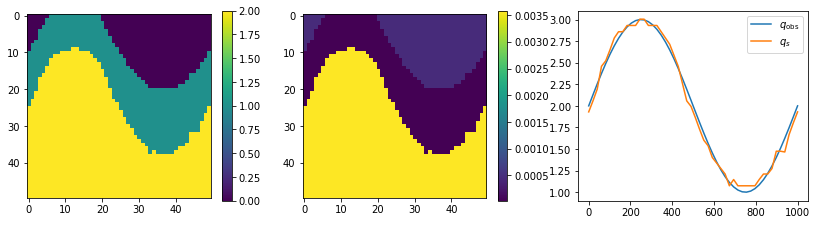

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,3.5))
im1 = ax1.imshow(lithology_new)
im2 = ax2.imshow(HP)
ax3.plot(inv.mesh.grid_coords[0], qobs, label=r'$q_{\mathrm{obs}}$')
ax3.plot(inv.mesh.grid_coords[0], qs, label=r'$q_{s}$')

ax3.legend()
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

In [58]:
ncells.astype(int)

array([[ 9,  8,  6,  4,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  1,  3,  5,  7,  9, 10, 12, 13, 15, 16, 17, 18,
        18, 19, 19, 20, 20, 20, 20, 20, 19, 19, 18, 17, 16, 15, 14, 13,
        11,  9],
       [14, 14, 14, 13, 13, 12, 12, 11, 10, 10,  9,  9,  9,  9,  9,  9,
        10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 15, 16, 16, 16, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 16, 16, 15,
        15, 14],
       [25, 27, 29, 31, 33, 36, 37, 38, 39, 39, 40, 40, 40, 40, 40, 40,
        39, 38, 38, 37, 35, 32, 30, 28, 26, 23, 22, 20, 18, 17, 15, 14,
        13, 13, 12, 12, 12, 11, 12, 12, 12, 13, 14, 15, 16, 17, 19, 21,
        22, 25]])

Make a movie

In [59]:
inv.log = True
inv.store = []
inv.niter = 0

res = minimize(adjoint_model, x, args=(ncol, inv), jac=True, bounds=bounds)

In [84]:
min_HP = 1.0
max_HP = 0.0

for i in xrange(2, inv.niter):
    xi = inv.store[i]
    min_HP = min(xi[:nl].min(), min_HP)
    max_HP = max(xi[:nl].max(), max_HP)

print min_HP, max_HP

0.0 0.003607836209109874


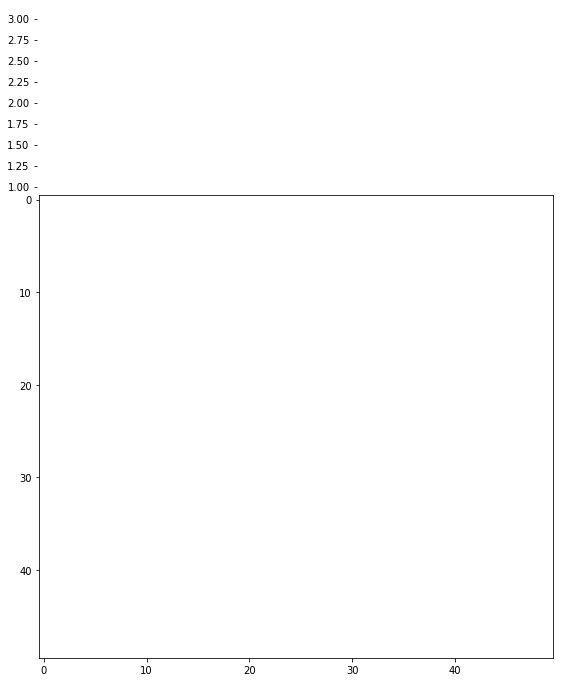

In [85]:
from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
        comment='Movie support!')
writer = FFMpegWriter(fps=5, metadata=metadata)



fig = plt.figure(1, figsize=(8, 10))
gs = GridSpec(2,1, height_ratios=[2,5], wspace=0.1, hspace=0.0)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95)


with writer.saving(fig, 'sinusoidal_HP.mp4', 100):
    for i in xrange(inv.niter):
        
        xi = inv.store[i]
        ncells = forward_model_ncells(xi, ncol, inv)
        lithology_new = construct_lithology(inv, ncells)

        HP = np.zeros_like(lithology_new, dtype=np.float)
        for l, lith in enumerate(inv.lithology_index):
            mask = lithology_new == lith
            HP[mask] = xi[l]

        qs = np.sum(HP*inv.grid_delta[0], axis=0)
        
        # plot surface heat flow
        ax1 = fig.add_subplot(gs[0], ylim=[qobs.min(), qobs.max()])
        ax1.get_xaxis().set_visible(False)
        ax1.set_yticklabels([])
        ax1.set_frame_on(False)
        ax1.grid(True)
        ax1.plot(inv.mesh.grid_coords[0], qobs, label=r'$q_{\mathrm{obs}}$')
        ax1.plot(inv.mesh.grid_coords[0], qs, label=r'$q_{s}$')
        ax1.legend()
        
        
        # plot lithology heat production
        ax2 = fig.add_subplot(gs[1])
        ax2.axis('off')
        im2 = ax2.imshow(HP, aspect=0.9, cmap=cmx.YlOrRd, vmin=min_HP, vmax=max_HP)
        writer.grab_frame()
        
        ax1.cla()
        ax2.cla()

Now we try to make this animation smoother

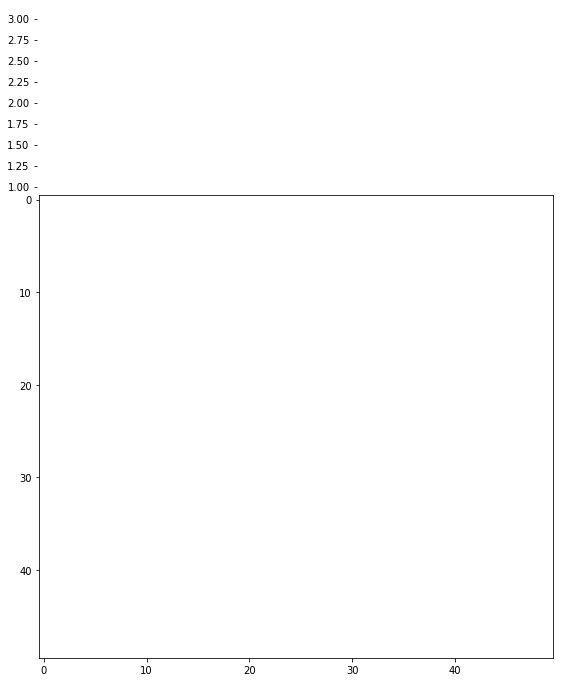

In [91]:
def reconstruct_HP_qs(x, ncol, inv):
    ncells = forward_model_ncells(xi, ncol, inv)
    lithology_new = construct_lithology(inv, ncells)

    HP = np.zeros_like(lithology_new, dtype=np.float)
    for l, lith in enumerate(inv.lithology_index):
        mask = lithology_new == lith
        HP[mask] = xi[l]

    qs = np.sum(HP*inv.grid_delta[0], axis=0)
    return HP, qs

def plot_qs(ax, qs):
    ax.get_xaxis().set_visible(False)
    ax.set_yticklabels([])
    ax.set_frame_on(False)
    ax.grid(True)
    ax.plot(inv.mesh.grid_coords[0], qobs, label=r'$q_{\mathrm{obs}}$')
    ax.plot(inv.mesh.grid_coords[0], qs, label=r'$q_{s}$')
    ax.legend()
    return

def plot_HP(ax, HP):
    ax.axis('off')
    ax.imshow(HP, aspect=0.9, cmap=cmx.YlOrRd, vmin=min_HP, vmax=max_HP)
    return


FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
        comment='Movie support!')
fps = 10
framerate = 25
writer = FFMpegWriter(fps=framerate, metadata=metadata)

frame_scale = np.linspace(0, 1, framerate-fps)


fig = plt.figure(1, figsize=(8, 10))
gs = GridSpec(2,1, height_ratios=[2,5], wspace=0.1, hspace=0.0)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95)


with writer.saving(fig, 'sinusoidal_HP.mp4', 100):
    for i in xrange(5, inv.niter-1):
        
        xi0 = inv.store[i]
        xi1 = inv.store[i+1]
        
        for frame in frame_scale:
            xi = xi0*(1.0 - frame) + xi1*frame
        
            HP, qs = reconstruct_HP_qs(xi, ncol, inv)

            # plot surface heat flow
            ax1 = fig.add_subplot(gs[0], ylim=[qobs.min(), qobs.max()])
            plot_qs(ax1, qs)

            # plot lithology heat production
            ax2 = fig.add_subplot(gs[1])
            plot_HP(ax2, HP)

            writer.grab_frame()

            ax1.cla()
            ax2.cla()